In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 🔵 **Dependencities**

In [2]:
!pip install -q torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 9.6 MB/s eta 0:00:00


In [3]:
#for windows
!pip install -q soundfile
#for linux
!pip install -q sox

In [4]:
!pip install -q librosa

# 🔵 **Import**

In [5]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F

import torchaudio
from torchaudio import datasets
from torchaudio import transforms as T
from torchaudio import models
from torchaudio import pipelines

from torch.nn.utils.rnn import pad_sequence

import numpy  as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from torchmetrics import Accuracy
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import librosa

from IPython.display import Audio

In [6]:
str(torchaudio.get_audio_backend())

<ipython-input-6-4bc9ba66fd25>:1: UserWarning: torchaudio._backend.get_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  str(torchaudio.get_audio_backend())


'None'

In [7]:
print(torch.__version__)
print(torchaudio.__version__)

2.1.0+cu118
2.1.0+cu118


# 🔵 **Utils**

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [9]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

In [10]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [11]:
def print_stats(waveform, sample_data_rate = None, src = None):
  if src:
    print("_" * 10)
    print("Source:", src)
    print("_" * 10)

  if sample_rate:
    print("Sample Rate: ", sample_rate)

  print('Shape: ', tuple(waveform.shape))
  print('DType: ', waveform.dtype)
  print(f" - Max:   {waveform.max().item():6.3f}")
  print(f" - Min:   {waveform.min().item():6.3f}")
  print(f" - Mean:   {waveform.mean().item():6.3f}")
  print(f" - Std Dev:   {waveform.std().item():6.3f}")
  print()
  print(waveform)
  print()

In [12]:
def plot_waveform(waveform, sample_rate, title = 'Waveform', xlim = None, ylim = None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth = 1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channels {c + 1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)

    figure.suptitle(title)
    plt.show(block = False)

In [13]:
def plot_spectrogram(specgram, title = None, ylabel = 'freq_bin'):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(T.AmplitudeToDB()(specgram), origin = 'lower')
  fig.colorbar(im, ax = axs)
  plt.show(block = False)

# 🔵 **LoadAudio**

In [14]:
Audio('/content/audio_LJ025-0076.wav')

In [15]:
metadata = torchaudio.info('/content/audio_LJ025-0076.wav')
print(metadata)

AudioMetaData(sample_rate=22050, num_frames=185146, num_channels=1, bits_per_sample=16, encoding=PCM_S)


In [16]:
waveform, sample_rate = torchaudio.load('/content/audio_LJ025-0076.wav')

In [17]:
waveform.shape

torch.Size([1, 185146])

In [18]:
sample_rate

22050

In [19]:
print_stats(waveform, sample_rate)

Sample Rate:  22050
Shape:  (1, 185146)
DType:  torch.float32
 - Max:    0.412
 - Min:   -0.340
 - Mean:    0.000
 - Std Dev:    0.065

tensor([[ 0.0000,  0.0000, -0.0001,  ..., -0.0002, -0.0004, -0.0006]])



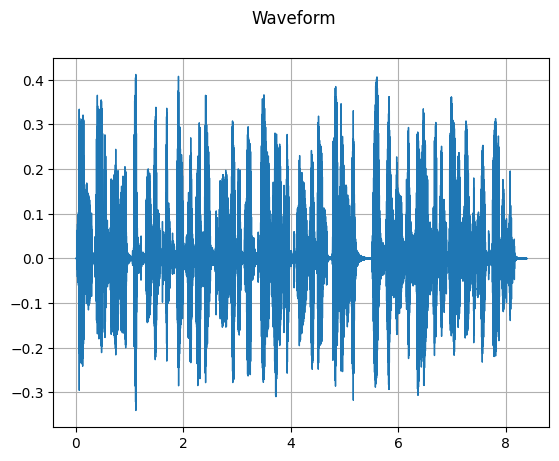

In [20]:
plot_waveform(waveform, sample_rate)

In [21]:
Audio(waveform.numpy(), rate = sample_rate)

Sample Rate:  22050
Shape:  (1, 10000)
DType:  torch.float32
 - Max:    0.365
 - Min:   -0.211
 - Mean:    0.000
 - Std Dev:    0.054

tensor([[-0.0649, -0.0681, -0.0695,  ..., -0.0119, -0.0171, -0.0197]])



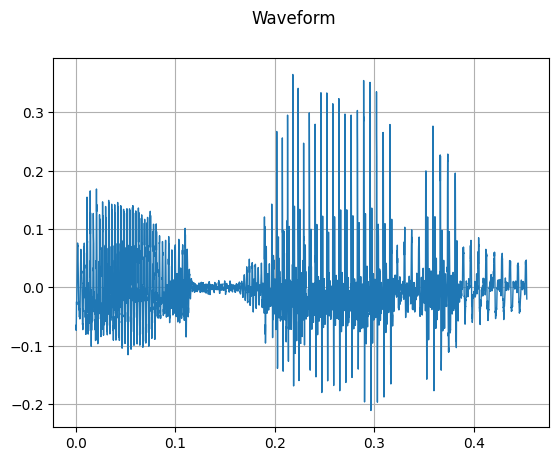

In [22]:
waveform, sample_rate = torchaudio.load('/content/audio_LJ025-0076.wav', num_frames = 10000, frame_offset = 4000)
print_stats(waveform, sample_rate)
plot_waveform(waveform, sample_rate)
Audio(waveform.numpy(), rate = sample_rate)

# 🔵 **Save**

In [23]:
torchaudio.save('/content/steam.wav', waveform, sample_rate = sample_rate)

# 🔵 **Transform**

In [24]:
waveform, sample_rate = torchaudio.load('/content/audio_LJ025-0076.wav')

## 🔵 **Feature Extraction**

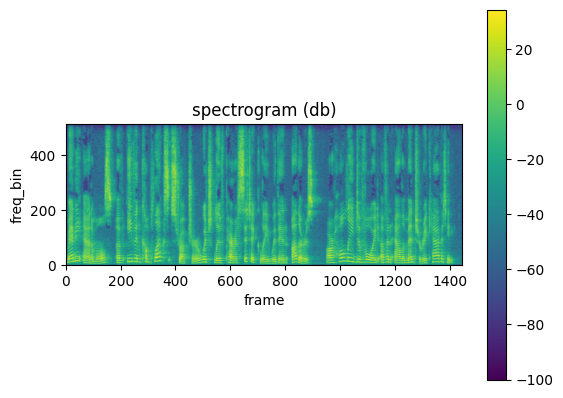

In [25]:
spectrogram = T.Spectrogram(n_fft = 1024, hop_length = 128)
spec = spectrogram(waveform) #n_fft / 2 + 1 = shape[1]
plot_spectrogram(spec[0])

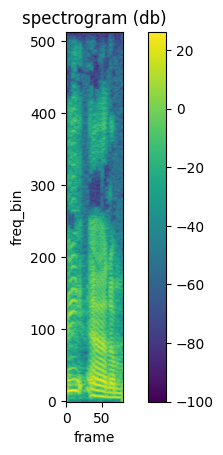

In [26]:
waveform, sample_rate = torchaudio.load('/content/steam.wav')
spec = spectrogram(waveform) #n_fft / 2 + 1 = shape[1]
plot_spectrogram(spec[0])

In [27]:
waveform, sample_rate = torchaudio.load('/content/audio_LJ025-0076.wav')
spectrogram = T.Spectrogram(n_fft = 1024, hop_length = 128)
spec = spectrogram(waveform) #n_fft / 2 + 1 = shape[1]
waveform = T.InverseSpectrogram(n_fft = 1024, hop_length = 128)(spec.type(torch.complex64))
Audio(waveform.numpy(), rate = sample_rate)

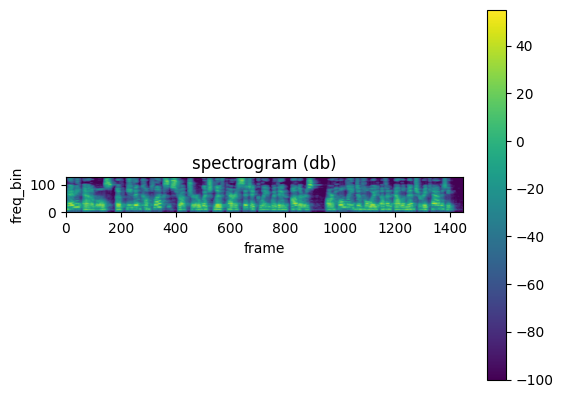

In [28]:
mel_spectrogram = T.MelSpectrogram(sample_rate = sample_rate, n_fft = 1024, hop_length = 128)
mel_spec = mel_spectrogram(waveform)
plot_spectrogram(mel_spec[0])

## 🔵 **Augmentation**

In [29]:
freq_mask = T.FrequencyMasking(freq_mask_param = 200)
masked = freq_mask(spec)
masked.shape

torch.Size([1, 513, 1447])

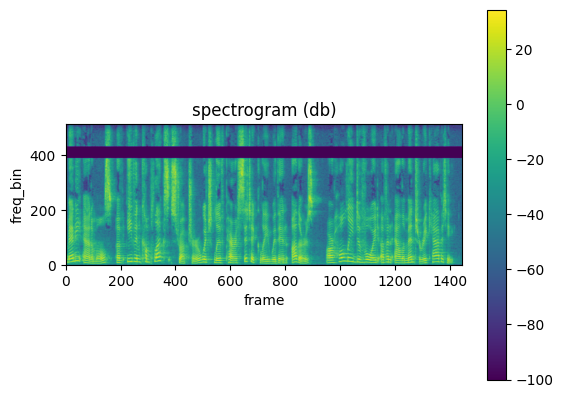

In [30]:
plot_spectrogram(masked[0])

In [31]:
time_mask = T.TimeMasking(time_mask_param = 200)
masked = time_mask(spec)
masked.shape

torch.Size([1, 513, 1447])

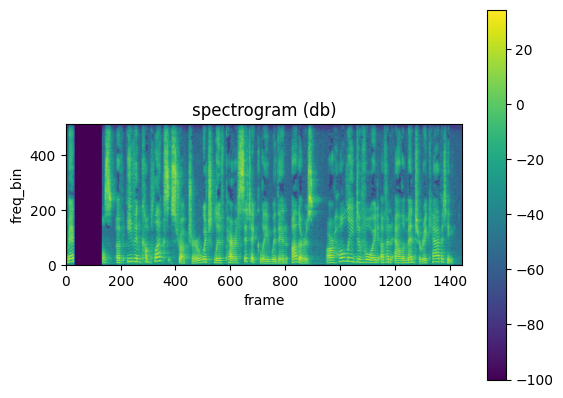

In [32]:
plot_spectrogram(masked[0])

In [33]:
time_stretch = T.TimeStretch(hop_length = 128, n_freq = 513, fixed_rate = 2)
masked = time_stretch(spec)
masked.shape

torch.Size([1, 513, 724])

<ipython-input-34-afbc511d5d1b>:1: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at ../aten/src/ATen/native/Copy.cpp:299.)
  plot_spectrogram(masked[0].type(torch.float64))


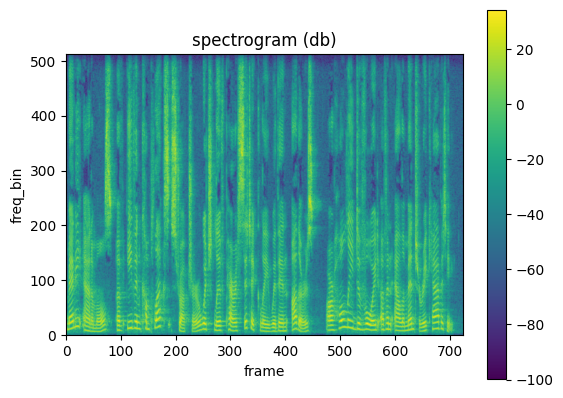

In [34]:
plot_spectrogram(masked[0].type(torch.float64))

In [35]:
fade = T.Fade(fade_in_len = sample_rate, fade_out_len = 4 * sample_rate)
masked = fade(waveform)
masked.shape

torch.Size([1, 185088])

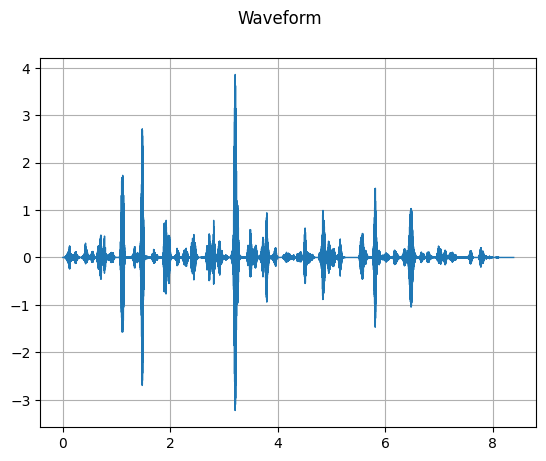

In [36]:
plot_waveform(masked, sample_rate)

In [37]:
Audio(masked, rate = sample_rate)

## 🔵 **Sequential**

In [38]:
transform = nn.Sequential(T.MelSpectrogram(sample_rate = sample_rate, n_fft = 1024, hop_length = 128, n_mels = 100), T.FrequencyMasking(freq_mask_param = 20),
                          T.TimeMasking(time_mask_param = 200))

In [39]:
masked = transform(waveform)
masked.shape

torch.Size([1, 100, 1447])

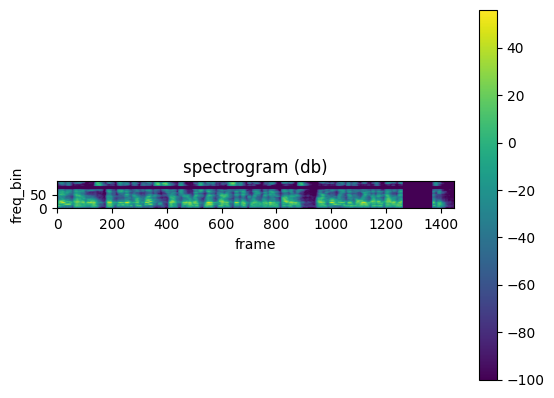

In [40]:
plot_spectrogram(masked[0])

## 🔵 **Utils**

In [41]:
resample = T.Resample(orig_freq = sample_rate, new_freq = 4000)
resampled = resample(waveform)
Audio(resampled.numpy(), rate = 4000)

In [42]:
resampled.shape, waveform.shape

(torch.Size([1, 33577]), torch.Size([1, 185088]))

# 🔵 **Dataset**

In [43]:
train_set = datasets.SPEECHCOMMANDS('/content/', download = True, subset = 'training')

100%|██████████| 2.26G/2.26G [00:59<00:00, 40.8MB/s]


In [44]:
valid_set = datasets.SPEECHCOMMANDS('/content/', subset = 'validation', download = True)
test_set  = datasets.SPEECHCOMMANDS('/content/', subset = 'testing', download = True)

In [45]:
len(train_set), len(valid_set), len(test_set)

(84843, 9981, 11005)

In [46]:
sample, sample_rate, _, _, _ = train_set[10000]

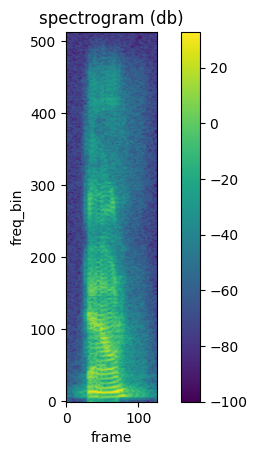

In [47]:
spec = spectrogram(sample)
plot_spectrogram(spec[0])
Audio(sample, rate = sample_rate)

In [48]:
labels = sorted(set([b[2] for b in valid_set]))
labels2nums = {label:num for num, label in enumerate(labels)}

In [49]:
labels2nums

{'backward': 0,
 'bed': 1,
 'bird': 2,
 'cat': 3,
 'dog': 4,
 'down': 5,
 'eight': 6,
 'five': 7,
 'follow': 8,
 'forward': 9,
 'four': 10,
 'go': 11,
 'happy': 12,
 'house': 13,
 'learn': 14,
 'left': 15,
 'marvin': 16,
 'nine': 17,
 'no': 18,
 'off': 19,
 'on': 20,
 'one': 21,
 'right': 22,
 'seven': 23,
 'sheila': 24,
 'six': 25,
 'stop': 26,
 'three': 27,
 'tree': 28,
 'two': 29,
 'up': 30,
 'visual': 31,
 'wow': 32,
 'yes': 33,
 'zero': 34}

In [56]:
def collate_fn(batch):
  samples = [b[0][0] for b in batch]
  samples = pad_sequence(samples, batch_first = True)
  samples = torchaudio.functional.resample(samples, 16000, 8000).unsqueeze(1)
  labels  = [labels2nums[b[2]] for b in batch]
  labels  = torch.LongTensor(labels)
  return samples, labels

In [57]:
train_loader = DataLoader(train_set, batch_size = 64, shuffle = True, collate_fn = collate_fn)
valid_loader = DataLoader(valid_set, batch_size = 128, shuffle = False, collate_fn = collate_fn)
test_loader  = DataLoader(test_set , batch_size = 128, shuffle = False, collate_fn = collate_fn)

In [58]:
samples, labels = next(iter(train_loader))
samples.shape, labels

(torch.Size([64, 1, 8000]),
 tensor([ 5,  3, 17, 19,  7, 10, 11, 17,  7, 21, 29, 20, 27, 30, 27, 24, 18,  6,
         26, 24, 28,  1, 33, 19, 33,  7, 26, 26, 16, 11, 33, 17, 18, 23, 13,  7,
         22, 19, 33, 19, 29, 16, 18, 24, 18, 17, 26, 21, 24, 29, 22, 10, 27, 20,
         27, 19, 10, 23, 28,  8, 19, 24, 22, 30]))

# 🔵 **Model**

## 🔵 **DefineModel**

In [53]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)

In [54]:
model = M5(n_input = 1, n_output = 35).to(device)
num_trainable_params(model)

0.026915

In [55]:
model

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=35, bias=True)
)

## 🔵 **PretrainedModel**

In [93]:
bundle = pipelines.WAV2VEC2_BASE
bundle

Wav2Vec2Bundle(_path='wav2vec2_fairseq_base_ls960.pth', _params={'extractor_mode': 'group_norm', 'extractor_conv_layer_config': [(512, 10, 5), (512, 3, 2), (512, 3, 2), (512, 3, 2), (512, 3, 2), (512, 2, 2), (512, 2, 2)], 'extractor_conv_bias': False, 'encoder_embed_dim': 768, 'encoder_projection_dropout': 0.1, 'encoder_pos_conv_kernel': 128, 'encoder_pos_conv_groups': 16, 'encoder_num_layers': 12, 'encoder_num_heads': 12, 'encoder_attention_dropout': 0.1, 'encoder_ff_interm_features': 3072, 'encoder_ff_interm_dropout': 0.0, 'encoder_dropout': 0.1, 'encoder_layer_norm_first': False, 'encoder_layer_drop': 0.05, 'aux_num_out': None}, _sample_rate=16000, _normalize_waveform=False, _model_type='Wav2Vec2')

In [ ]:
model = bundle.get_model()
model

In [ ]:
model.feature_extractor

In [ ]:
model.encoder

In [97]:
model.training

False

In [116]:
out = model(torch.randn((2, 16000), device = device))
out[0].shape

torch.Size([2, 49, 768])

In [120]:
class Wav2VecCLS(nn.Module):
  def __init__(self, num_cls):
    super().__init__()

    bundle = pipelines.WAV2VEC2_BASE
    self.feature_extractor = bundle.get_model()
    self.fc = nn.LazyLinear(num_cls)

  def forward(self, x):
    y = self.feature_extractor(x)
    y = self.fc(y[0])
    return y

In [ ]:
model = Wav2VecCLS(35).to(device)
model

In [123]:
model(torch.randn((2, 16000), device = device)).shape

torch.Size([2, 49, 35])

In [125]:
num_trainable_params(model), model.feature_extractor.training, model.fc.training

(94.397859, False, True)

# 🔷 **Train**

In [86]:
def train_one_epoch(model,train_loader,loss_func,optimizer,epoch):
  model.train()
  train_loss=AverageMeter()
  train_acc=Accuracy(task='multiclass',num_classes=35).to(device)
  with tqdm(train_loader,unit='batch') as tepoch:
    for x,y in tepoch:
        if epoch is not None:
          tepoch.set_description(f'Epoch{epoch}')
        x=x.to(device)
        y=y.to(device)
        yp=model(x)
        loss=loss_func(yp.squeeze(),y)
        train_loss.update(loss.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_acc(yp.squeeze(),y)
        tepoch.set_postfix(loss=train_loss.avg,
                      accuracy=100*train_acc.compute().item())


  return model,train_loss.avg,train_acc.compute().item()

# 🔷 **Evaluate**

In [87]:
def validation(model,valid_loader,loss_func):
  model.eval()
  valid_loss=AverageMeter()
  valid_acc=Accuracy(task='multiclass',num_classes=35).to(device)

  for j,(x,y) in enumerate(valid_loader):
    x=x.to(device)
    y=y.to(device)
    yp=model(x)
    loss=loss_func(yp.squeeze(),y)
    valid_loss.update(loss.item())
    valid_acc(yp.squeeze(),y)

  print(f'valid loss={valid_loss.avg:.4},accuracy={valid_acc.compute():.4}')
  print()

  return valid_loss.avg,valid_acc.compute().item()

# 🔵 **SpeechCommandClassification**

## 🔵 **Step1**

In [65]:
model = M5(n_input = 1, n_output = 35).to(device)
loss_fn = nn.CrossEntropyLoss()

x_batch, y_batch = next(iter(train_loader))
output = model(x_batch.to(device))
loss = loss_fn(output.squeeze(), y_batch.to(device))
loss

tensor(3.7365, device='cuda:0', grad_fn=<NllLossBackward0>)

## 🔵 **Step2**

In [97]:
model = M5(n_input = 1, n_output = 35).to(device)

In [98]:
mini_batch,_=random_split(train_set,(500,len(train_set)-500))
mini_loader=DataLoader(mini_batch,batch_size=20,shuffle=True, collate_fn = collate_fn)

In [99]:
loss_fn=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=0.1)

In [100]:
for i in range(50):
  model,_,_=train_one_epoch(model,mini_loader,loss_fn,optimizer,i)

Epoch49: 100%|██████████| 25/25 [00:03<00:00,  8.29batch/s, accuracy=97.4, loss=0.168]


## 🔵 **Step3**

In [ ]:
num_epochs = 5
lr_list    = [0.5, 0.1, 0.01]
results    = []

for lr in lr_list:
  sub_result = []
  print(f'LR={lr}')

  model = M5(n_input = 1, n_output = 35).to(device)

  optimizer = optim.SGD(model.parameters(), lr = lr, momentum = 0.9)
  loss_func = nn.CrossEntropyLoss()

  for epoch in range(num_epochs):
    model, train_loss, _ = train_one_epoch(model, train_loader, loss_func, optimizer, epoch)

    if epoch == 0:
      sub_result.append(train_loss)
    if epoch == 4:
      sub_result.append(train_loss)

  results.append(sub_result)

  print()

LR=0.5


Epoch0:  13%|█▎        | 169/1326 [00:43<04:18,  4.47batch/s, accuracy=4.9, loss=3.49]